In [1]:
import pickle
import numpy as np
import xarray as xr
import pandas as pd
#import wrf

#import dask
#import dask.array as da
#from dask import delayed

import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader

import geopandas
import regionmask
from matplotlib.path import Path
import matplotlib.ticker as mticker

from scipy.ndimage.measurements import center_of_mass

from glob import glob

from datetime import datetime, timedelta
import os

ERROR 1: PROJ: proj_create_from_database: Open of /home/bwallace/anaconda3/envs/geo/share/proj failed
/var/tmp/pbs.1882828.polaris-pbs-01.hsn.cm.polaris.alcf.anl.gov/ipykernel_685180/4085831254.py:27: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.measurements import center_of_mass


In [2]:
def mask_data(arr_shape, states, lon, lat, conus_shapefile_path='shp/CONUS.shp'):
    r"""Masks an input xarray dataset using the
    two character state IDs in states based on the 
    lon_name and lat_name coordinates in input_dataset and
    if they are within the given list of states. Original dataset 
    is not modified.
    
    Parameters
    ----------
    input_dataset: xarray dataset
        Dataset that you want to mask. Must have a lon and lat coordinate.
    states: list or ndarray
        List of states used to extract data subset.      
    lon_name: str
        Name of longitude coordinate in input_dataset. Default is 'lon'.
    lat_name: str
        Name of latitude coordinate in input_dataset. Default is 'lat'.
    conus_shapefile_path: str
        Path to shapefile used to extract geography information.
        
    Returns
    -------
    output_dataset: xarray dataset
        Modified input_dataset where grids not in states are set to nan.
    """
    
    ones=np.ones(arr_shape)
    
    usa = geopandas.read_file(conus_shapefile_path)
    usa = usa[usa.STUSPS.isin(states)]

    state_mask = regionmask.mask_geopandas(usa, lon, lat)
    
    ma = state_mask.values
    ma[~np.isnan(ma)] = 1
    output_dataset = ones * ma
    
    return output_dataset

In [3]:
# Set some projections for our data (Plate Carree)
# and output maps (Lambert Conformal)

# Data projection;
dataproj = ccrs.PlateCarree()

# Plot projection
# The look you want for the view, LambertConformal for mid-latitude view
plotproj = ccrs.LambertConformal(central_longitude=-96.,
                                 central_latitude=40.,
                                 standard_parallels=[30, 60])

In [4]:
coarsen_size=20 #make sure this is consistent with the coarsen_size specified in calculate_mcs_anomaly

wrf_native_coords=xr.open_dataset('../data/geog_info.nc')
wrf_lat=wrf_native_coords.XLAT_M[0]
wrf_lon=wrf_native_coords.XLONG_M[0]

wrf_lat_coarse=wrf_lat.coarsen(south_north=coarsen_size,boundary='trim').mean()\
.coarsen(west_east=coarsen_size,boundary='trim').mean()
wrf_lon_coarse=wrf_lon.coarsen(south_north=coarsen_size,boundary='trim').mean()\
.coarsen(west_east=coarsen_size,boundary='trim').mean()

# request data for use by geopandas
resolution = '110m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)
df = geopandas.read_file(shpfilename)
df=df[df.TYPE=='Country']
USA=df[df.SOV_A3=='US1']

shpfilename_lakes = shapereader.natural_earth('110m', 'physical', 'lakes')
lakes_df = geopandas.read_file(shpfilename_lakes)

lakes_df=lakes_df[lakes_df.name_alt=='Great Lakes']#.geometry

#glakes_mask=regionmask.mask_geopandas(lakes_df.geometry,wrf_lon,wrf_lat)
#usa_mask=regionmask.mask_geopandas(USA.geometry,wrf_lon,wrf_lat)

In [5]:
regions = {'SP': ['TX', 'OK', 'KS'],
           'NP': ['NE', 'SD', 'ND'],
           'MW': ['WI', 'MI', 'OH', 'IL', 'IN', 'MN', 'IA', 'MO', 'KY'],
           'SE': ['AR', 'LA', 'TN', 'MS', 'AL', 'SC', 'NC', 'FL', 'GA'],
           'NE': ['NJ', 'PA', 'NY', 'VT', 'NH', 'CT', 'VA', 'WV', 'MD', 'DC', 'DE', 'RI', 'MA', 'ME'],}
           #'EC': []}

#ECONUS is comprised of states in all other regions
#[regions['EC'].extend(regions[x]) for x in regions.keys() if x!='EC'];


region_id = {#'EC': 'ECONUS', 
                'NP': 1, 
                'SP': 2, 
                'MW': 3, 
                'SE': 4, 
                'NE': 5}

region_names = {#'EC': 'ECONUS', 
                1: 'Northern Plains', 
                2: 'Southern Plains', 
                3: 'Midwest', 
                4: 'Southeast', 
                5: 'Northeast'}

In [6]:
#region_string_array=np.repeat(np.array(['Undefined']*1399)[np.newaxis],899,axis=0)
region_string_array=np.repeat(np.array([0]*1399)[np.newaxis],899,axis=0)

for region in regions.keys():
    print(region)
    masked_states=xr.DataArray(mask_data(wrf_native_coords.HGT_M[0].shape,regions[region],
                       wrf_native_coords.XLONG_M[0],wrf_native_coords.XLAT_M[0]))
    
    region_string_array=np.where(~np.isnan(masked_states),region_id[region],region_string_array)

region_xr_array=xr.DataArray(region_string_array)

SP
NP
MW
SE
NE


In [7]:
region_key={
    'Northeast':5,
    'Southeast':4,
    'Midwest':3,
    'Southern Plains':2,
    'Northern Plains':1
}

letters=['a.','b.','c.','d.','e.','f.','g.','h.','i.','k.','l.','m.','n.','o.','p.','q.','r.','s.','t.','u.','v.']

In [8]:
list(region_key.keys())

['Northeast', 'Southeast', 'Midwest', 'Southern Plains', 'Northern Plains']

In [9]:
allpaths_ds={}

for sim in ['historical','end_of_century_8p5']:
    for season in ['ALL']:
        for forcing in ['Forced', 'Unforced', 'All']:
            for unique_region in region_key.keys():
                if os.path.isfile('../data/historical/'+unique_region+'_'+season+'_'+forcing+'_anomaly.nc') &\
                os.path.isfile('../data/end_of_century_8p5/'+unique_region+'_'+season+'_'+forcing+'_anomaly.nc'):
                    
                    allpaths_ds[sim+unique_region+season+forcing+'_anom']=xr.open_dataset(
                    '../data/'+sim+'/'\
                                                                 +unique_region+'_'+season+'_'+forcing+'_anomaly.nc')
                    allpaths_ds[sim+unique_region+season+forcing+'_mean']=xr.open_dataset(
                    '../data/'+sim+'/'\
                                                                 +unique_region+'_'+season+'_'+forcing+'_mean.nc')

In [10]:
pres_arr=xr.open_dataset('../data/vert_coords.nc')

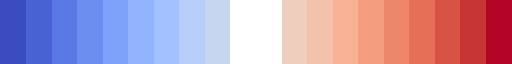

In [11]:
new_colors=plt.get_cmap('coolwarm')(np.linspace(0,1,256))
new_colors[120:140]=[1,1,1,1]

seis_cmap=mcolors.ListedColormap(new_colors).resampled(20)
seis_cmap

In [12]:
xy_points=np.vstack((wrf_lon.values.flatten(),wrf_lat.values.flatten())).T
#xy_points_cesm=np.vstack((CESM_lon.flatten(),CESM_lat.flatten())).T

vert_dict={}
vert_dict['Northeast']=[(-80,52),(-97,52),(-97,36),(-80,36)]
vert_dict['Southeast']=[(-105,32),(-89,32),(-89,47),(-105,47)]
vert_dict['Midwest']=[(-116,37),(-98,37),(-98,55),(-116,55)]
vert_dict['Southern Plains']=[(-117,29),(-101,29),(-101,44),(-117,44)]
vert_dict['Northern Plains']=[(-119,36),(-105,36),(-105,51),(-119,51)]

masks={}
for key in vert_dict.keys():
    p=Path(vert_dict[key])
    grid=p.contains_points(xy_points)
    rgnbnds=grid.reshape(wrf_lat.shape)
    rgnbnds=xr.DataArray(rgnbnds)#.where(~np.isnan(usa_mask.values)).where(np.isnan(glakes_mask.values))
    masks[key]=rgnbnds.rename({'dim_0':'south_north','dim_1':'west_east'})

/var/tmp/pbs.1882828.polaris-pbs-01.hsn.cm.polaris.alcf.anl.gov/ipykernel_685180/836450101.py:50: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour=cr.collections[3].get_paths()[0]
/var/tmp/pbs.1882828.polaris-pbs-01.hsn.cm.polaris.alcf.anl.gov/ipykernel_685180/836450101.py:52: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour=cr.collections[0].get_paths()[0]
/var/tmp/pbs.1882828.polaris-pbs-01.hsn.cm.polaris.alcf.anl.gov/ipykernel_685180/836450101.py:52: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour=cr.collections[0].get_paths()[0]
/var/tmp/pbs.1882828.polaris-pbs-01.hsn.cm.polaris.alcf.anl.gov/ipykernel_685180/836450101.py:52: MatplotlibDeprecationWarning: The collections attribute was deprecated in 

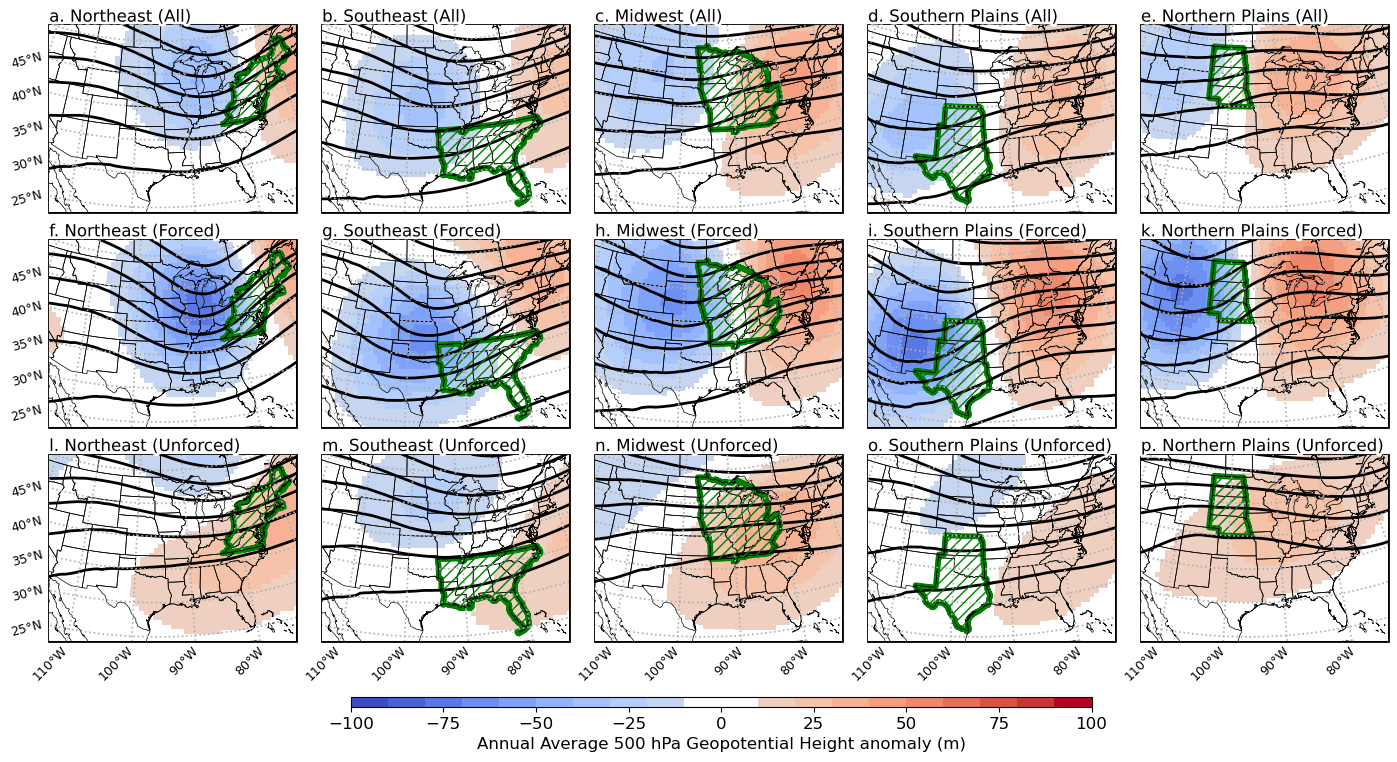

In [13]:
sim='historical'
ssn='ALL'

all_region_list = list(region_key.keys())*3

fig=plt.figure(figsize=(18,8))
gs=fig.add_gridspec(3,5)

for i,r in enumerate(all_region_list):

    if i//5==0:
        forcing = 'All'
    elif i//5==1:
        forcing='Forced'
    elif i//5==2:
        forcing='Unforced'
    
    ax=fig.add_subplot(gs[i//5,i%5],projection=plotproj)
    ax.set_extent([-113., -74, 24, 50.5],ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE,linewidth=0.5,zorder=6)
    ax.add_feature(cfeature.STATES,linewidth=0.5,zorder=6)

    mesh_field=allpaths_ds[sim+r+ssn+forcing+'_anom']['GHT_PL'].\
    sel(num_press_levels_stag=pres_arr['P_PL'][0]==50000)[0]
    
    ax.contour(wrf_lon_coarse,wrf_lat_coarse,allpaths_ds[sim+r+ssn+forcing+'_mean']['GHT_PL'].\
               sel(num_press_levels_stag=pres_arr['P_PL'][0]==50000)[0],
               np.arange(5000,6550,50),colors='k',linewidths=2,linestyles='-',
               transform=dataproj,zorder=6)

    pmsh=ax.pcolormesh(wrf_lon_coarse,wrf_lat_coarse,mesh_field,
               vmin=-100,vmax=100,cmap=seis_cmap,
               transform=dataproj,zorder=5)

    ##########################################################################################
    dashed_region=True
    if dashed_region:
        mpl.rcParams['hatch.color']='green'

        if region_key[r]==5:
            cr=ax.contourf(wrf_lon,wrf_lat,
                           region_xr_array.where(region_xr_array==region_key[r]),
                           colors=['none','none'],hatches=['','///'],transform=dataproj,zorder=6)
        else:
            cr=ax.contourf(wrf_lon,wrf_lat,
                           region_xr_array.where(region_xr_array==region_key[r]),
                           colors=['none','none'],hatches=['///',''],transform=dataproj,zorder=6)

        if region_key[r]==5:
            contour=cr.collections[3].get_paths()[0]
        else:
            contour=cr.collections[0].get_paths()[0]
        plot_poly=contour.to_polygons()[0]
        ax.plot(plot_poly[:,0],plot_poly[:,1],
                color='green',linewidth=4,
                transform=dataproj,linestyle='-',zorder=5)
    ##########################################################################################
    

    t=ax.text(0.,1.02,letters[i]+' '+r+' ('+forcing+')',
              horizontalalignment='left',
              size=12,color='k',
              path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
              transform=ax.transAxes,zorder=10)

    #if i==0:
    #    cbar_axs=[]
    #cbar_axs.append(ax)
    if i==len(all_region_list)-1:

        axins = inset_axes(
            ax,
            width="300%",  # width: 5% of parent_bbox width
            height="5%",  # height: 50%
            bbox_to_anchor=(-1.2, -1.3, 1, 1),
            bbox_transform=ax.transAxes,
            borderpad=0,
        )
        
        cbar=plt.colorbar(pmsh,cax=axins,orientation='horizontal')
        cbar.ax.tick_params(labelsize=12)
        cbar.set_label('Annual Average 500 hPa Geopotential Height anomaly (m)',fontsize=12)



    ll=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linestyle=':',lw=1.2,zorder=11)
    ll.top_labels=False
    ll.right_labels=False
    
    if i%5>0:
        ll.left_labels=False
    else:
        ll.left_labels=True

    if i//5<2:
        ll.bottom_labels=False
    else:
        ll.bottom_labels=True
        
    ll.xlocator = mticker.FixedLocator([-120,-110,-100,-90,-80,-70])
    ll.rotate_labels=True
    ll.xlabel_style = {'rotation':45,  'size':9}
    ll.ylabel_style = {'rotation':15, 'size':9}

    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)


plt.subplots_adjust(wspace=-0.1, hspace=0.15)
plt.show()
#plt.savefig('/eagle/climate_severe/bwallace_scratch/figs/ecd_cesm_wrf/domain.png',bbox_inches='tight')
plt.close()